In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


# Data Preparation

### Returns

In [4]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
settle_returns = (yen_futures[["Settle"]].pct_change() * 100)
settle_returns = settle_returns.replace(-np.inf, np.nan).dropna()
yen_futures['Settle Returns'] = settle_returns
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Settle Returns
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
from sklearn.linear_model import LinearRegression
yen_futures['Lagged Return'] = yen_futures['Settle Returns'].shift()
yen_futures.dropna(inplace=True)
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Settle Returns,Lagged Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2018']
test = yen_futures['2018':]

In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train['Lagged Return'].to_frame()
y_train = train['Settle']
X_test = test['Lagged Return'].to_frame()
y_test = test['Settle']

In [8]:
X_train

,Lagged Return
Date,
2014-02-18,0.409123
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
...,...
2018-12-24,-0.187545
2018-12-26,0.834485
2018-12-27,-0.893346


In [14]:
X_test

,Lagged Return
Date,
2018-01-02,0.224871
2018-01-03,0.297285
2018-01-04,-0.240479
2018-01-05,-0.213028
2018-01-08,-0.353933
...,...
2019-10-09,0.170931
2019-10-10,-0.410601
2019-10-11,-0.369458


# Linear Regression Model

In [15]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [16]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [17]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results['Predicted Return'] = predictions
results.head()

,Settle,Predicted Return
Date,,
2018-01-02,8940.5,8989.122043
2018-01-03,8919.0,8991.764588
2018-01-04,8900.0,8972.140535
2018-01-05,8868.5,8973.142252
2018-01-08,8874.0,8968.000382


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

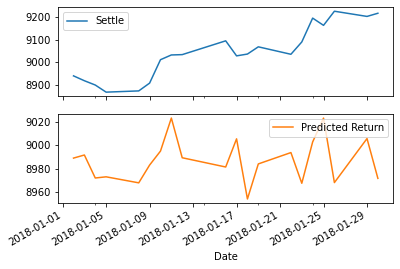

In [18]:
# Plot the first 20 predictions vs the true values
results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [20]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    results.Settle,
    results['Predicted Return']
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
RMSE = np.sqrt(mse)
print(f'Out-of-Sample Root Mean Squared Error (RMSE): {RMSE}')

Out-of-Sample Root Mean Squared Error (RMSE): 240.26710325707933


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [21]:
# Construct a dataframe using just the "y" training data:
ISP_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
ISP_results['in-sample'] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
ISP_mse = mean_squared_error(
    ISP_results.Settle,
    ISP_results['in-sample']
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
ISP_RMSE = np.sqrt(ISP_mse)
print(f'In-sample Root Mean Squared Error (RMSE): {ISP_RMSE}')

In-sample Root Mean Squared Error (RMSE): 516.5160603760565


# Conclusions

YOUR CONCLUSIONS HERE!

The 'out-of-sample' data has a lower RMSE, however the plots show the Settle price is actually higher than predicted.